# 2×2の分割表のオッズ比の信頼区間のシンプルな実装例

* 黒木玄
* 2021-10-24

χ²検定に付随するオッズ比の信頼区間の構成に関する詳しい解説が

* https://nbviewer.org/gist/genkuroki/19adb161b3f7894d6746010ed7bc6abe

にある。Fisher検定に付随するオッズ比の信頼区間の計算にはFisherの非心超幾何分布を使う。

信頼区間は「P値がα以上になるパラメーターの範囲」として計算される。

実際の計算では「P値がαに等しくなるパラメーター値」を数値計算することによって信頼区間を求める。

## P値函数と信頼区間函数のシンプルな実装

In [1]:
using Distributions
using Roots
using Optim
using Memoization
using StatsPlots
using StatsBase

default(fmt = :png)

using RCall
@rlibrary stats

safemul(x, y) = x == 0 ? x : x*y
safediv(x, y) = x == 0 ? x : x/y
x ⪅ y = x < y || x ≈ y

function minimizefunc(f, a, b, N = 100)
    x = range(a, b; length = N + 1)
    m, i = findmin(f, x)
    o = Optim.optimize(f, x[max(begin, i-1)], x[min(end, i+1)])
    minimum(o), Optim.minimizer(o)
end

function maximizefunc(f, a, b, N = 100)
    m, x = minimizefunc(x -> -f(x), a, b, N)
    -m, x
end

maximizefunc (generic function with 2 methods)

In [2]:
@memoize function ci_generic(pvalfunc, a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8)
    # find_zeros(f, a, b) returns the solutions of f(x) = 0 in the interval [a, b] 
    CI = exp.(find_zeros(t -> pvalfunc(a, b, c, d, exp(t)) - α, log(xmin), log(xmax)))
    length(CI) == 1 ? CI[1] < 1 ? (0.0, CI[1]) : (CI[1], Inf) : (CI[1], CI[end])
end

function delta(a, b, c, d, ω = 1.0)
    A = 1 - ω
    B = a + d + ω*(b + c)
    C = a*d - ω*b*c
    # solution of Ax² + Bx + C = 0 with −min(a,d) < x < min(b,c)
    2*C/(-B - √(B^2 - 4*A*C))
end

delta (generic function with 2 methods)

In [3]:
function chisq_stat(a, b, c, d, ω = 1.0)
    δ = delta(a, b, c, d, ω)
    safemul(δ^2, 1/(a + δ) + 1/(b - δ) + 1/(c - δ) + 1/(d + δ))
end

@memoize function pval_chisq(a, b, c, d, ω = 1.0)
    X² = chisq_stat(a, b, c, d, ω)
    ccdf(Chisq(1), X²)
end

ci_chisq(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_chisq, a, b, c, d, α; xmin, xmax)

ci_chisq (generic function with 2 methods)

In [4]:
function g_stat(a, b, c, d, ω = 1.0)
    δ = delta(a, b, c, d, ω)
    2(safemul(a, log(a) - log(a + δ)) + safemul(b, log(b) - log(b - δ))
    + safemul(c, log(c) - log(c - δ)) + safemul(d, log(d) - log(d + δ)))
end

@memoize function pval_gtest(a, b, c, d, ω = 1.0)
    X² = g_stat(a, b, c, d, ω)
    ccdf(Chisq(1), X²)
end

ci_gtest(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_gtest, a, b, c, d, α; xmin, xmax)

ci_gtest (generic function with 2 methods)

In [5]:
@memoize function pval_fisher(a, b, c, d, ω = 1.0)
    (a + b == 0 || c + d == 0 || a + c == 0 || b + d == 0) && return 1.0
    fnhg = FisherNoncentralHypergeometric(a + b, c + d, a + c, ω)
    p0 = pdf(fnhg, a)
    pval = sum(pdf(fnhg, k) for k in support(fnhg) if pdf(fnhg, k) ⪅ p0; init = 0.0)
    min(1, pval)
end

ci_fisher(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_fisher, a, b, c, d, α; xmin, xmax)

ci_fisher (generic function with 2 methods)

In [6]:
@memoize function pval_fisher_dos(a, b, c, d, ω = 1.0) # dos stands for "doubling one-side"
    (a + b == 0 || c + d == 0 || a + c == 0 || b + d == 0) && return 1.0
    fnhg = FisherNoncentralHypergeometric(a + b, c + d, a + c, ω)
    min(1, 2cdf(fnhg, a), 2ccdf(fnhg, a-1))
end

ci_fisher_dos(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_fisher_dos, a, b, c, d, α; xmin, xmax)

ci_fisher_dos (generic function with 2 methods)

In [7]:
@memoize function pval_2bins(a, b, c, d, θ1, ω = 1.0)
    (a + c == 0 || b + d == 0) && return 1.0
    θ2 = θ1/(θ1 + ω*(1 - θ1))
    n1, n2 = a + c, b + d
    bin1, bin2 = Binomial(n1, θ1), Binomial(n2, θ2)
    f0 = pval_fisher(a, b, c, d, ω)
    pval = sum(
        pdf(bin1, i) * pdf(bin2, j)
        for i in support(bin1) for j in support(bin2)
        if pval_fisher(i, j, n1-i, n2-j, ω) ⪅ f0
        ; init = 0.0)
    min(1, pval)
end

@memoize _pval_barnard(a, b, c, d, ω = 1.0) =
    maximizefunc(θ1 -> pval_2bins(a, b, c, d, θ1, ω), 0, 1)

pval_barnard(a, b, c, d, ω = 1.0) = 
    _pval_barnard(a, b, c, d, ω) |> first

ci_barnard(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_barnard, a, b, c, d, α; xmin, xmax)

ci_barnard (generic function with 2 methods)

In [8]:
oddsratio(a, b, c, d) = safediv(a*d, b*c)

@memoize function pval_logOR(a, b, c, d, ω = 1.0)
    (a == 0 || b == 0 || c == 0 || d == 0) && return 1.0
    μ = log(ω)
    σ = √(1/a + 1/b + 1/c + 1/d)
    X = log(oddsratio(a, b, c, d))
    Z = (X - μ)/σ
    min(1, 2ccdf(Normal(), abs(Z)))
end

ci_logOR(a, b, c, d, α = 0.05; xmin = 1e-8, xmax = 1e8) =
    ci_generic(pval_logOR, a, b, c, d, α; xmin, xmax)

ci_logOR (generic function with 2 methods)

In [9]:
A = [
    5 1
    1 6
]

@show pval_chisq(A...) pval_gtest(A...) pval_fisher(A...) pval_fisher_dos(A...) pval_logOR(A...) pval_barnard(A...);
@show ci_chisq(A...) ci_gtest(A...) ci_fisher(A...) ci_fisher_dos(A...) ci_logOR(A...) ci_barnard(A...);

pval_chisq(A...) = 0.01279058943430918
pval_gtest(A...) = 0.009133856147097242
pval_fisher(A...) = 0.029137529137529136
pval_fisher_dos(A...) = 0.05011655011655014
pval_logOR(A...) = 0.027044811610345332
pval_barnard(A...) = 0.02246093749999999
ci_chisq(A...) = (1.8543705409637725, 485.83566130067607)
ci_gtest(A...) = (2.1553584085337265, 1253.8232538522316)
ci_fisher(A...) = (1.3160740080497346, 805.4511383493298)
ci_fisher_dos(A...) = (0.9989677859199187, 1645.4760120577916)
ci_logOR(A...) = (1.471075573672915, 611.7972564474853)
ci_barnard(A...) = (1.3160740080497346, 630.4020802773103)


In [10]:
@rput A
R"fisher.test(A)"

RObject{VecSxp}

	Fisher's Exact Test for Count Data

data:  A
p-value = 0.02914
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
    0.9989672 1617.3083432
sample estimates:
odds ratio 
  19.74834 



Rの `fisher.test` の結果は本質的に以上の `pval_fisher` と `ci_fisher_dos` と一致する。

Rの `fisher.test` では表示されるP値と信頼区間のあいだに整合性がない。実際、上の場合にP値は５％未満なのに、95%信頼区間が帰無仮説のオッズ比の値1を含んでしまっている。

信頼区間の数値の `ci_fisher_dos` との微妙な違いはRでの実装における数値計算の許容誤差が大きいことが原因である。詳しくは以下のリンク先を参照：

* https://twitter.com/genkuroki/status/1422926792210280451

In [11]:
R"chisq.test(A)"

┌ Warning: RCall.jl: Warning in chisq.test(A) : Chi-squared approximation may be incorrect
└ @ RCall D:\.julia\packages\RCall\iMDW2\src\io.jl:160


RObject{VecSxp}

	Pearson's Chi-squared test with Yates' continuity correction

data:  A
X-squared = 3.7309, df = 1, p-value = 0.05342



Rの `chisq.test` はデフォルトでYatesの連続性補正を適用する。その結果は `fisher_dos` に近くなる。

Yatesの連続性補正はいかなる場合も使用しない方がよいと思う。

In [12]:
R"chisq.test(A, correct = FALSE)"

┌ Warning: RCall.jl: Warning in chisq.test(A, correct = FALSE) :
│   Chi-squared approximation may be incorrect
└ @ RCall D:\.julia\packages\RCall\iMDW2\src\io.jl:160


RObject{VecSxp}

	Pearson's Chi-squared test

data:  A
X-squared = 6.1978, df = 1, p-value = 0.01279



Rの `chisq.test` で補正をオフにすると、その結果は `chisq` に一致する。

Rの `chisq.test` はしつこく "Chi-squared approximation may be incorrect" と警告して来るが、この警告は必ずしも正しくない。

## P値函数のプロット

In [13]:
function plot_pvalfuncs(A, ωmin, ωmax; xtick = -20:20, ytick = 0:0.05:1)
    t = range(log(10, ωmin), log(10, ωmax), length=1000)
    p_chisq = pval_chisq.(A..., exp.(t))
    p_gtest = pval_gtest.(A..., exp.(t))
    p_fisher = pval_fisher.(A..., exp.(t))
    p_fisher_dos = pval_fisher_dos.(A..., exp.(t))
    p_logOR = pval_logOR.(A..., exp.(t))
    p_barnard = pval_barnard.(A..., exp.(t))

    plot(t, p_chisq; label="chisq")
    plot!(t, p_gtest; label="gtest", ls=:dash)
    plot!(t, p_fisher; label="fisher", ls=:dash)
    plot!(t, p_fisher_dos; label="fisher_dos", ls=:dashdot)
    plot!(t, p_barnard; label="barnard", ls=:dot)
    plot!(t, p_logOR; label="logOR", ls=:dot)
    title!("p-value functions for data A = $A")
    plot!(; xlabel="log₁₀(odds ratio)")
    plot!(; xtick=-20:20, ytick=0:0.05:1)
end

plot_pvalfuncs (generic function with 1 method)

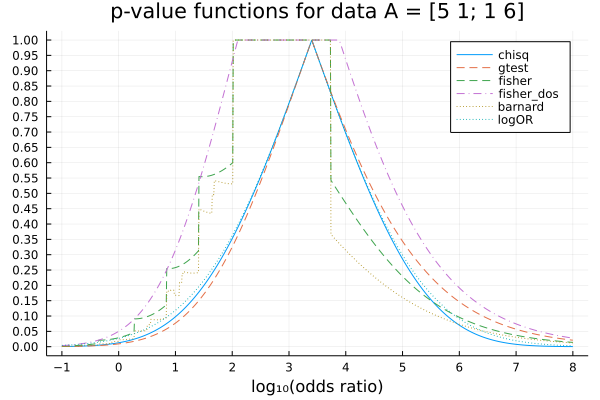

In [14]:
plot_pvalfuncs(A, 1e-1, 1e8)

## Barnard検定の最大値を取る前のP値函数のプロット

_pval_barnard(B..., 0.9) = (0.051991159823297, 0.30750488354492755)


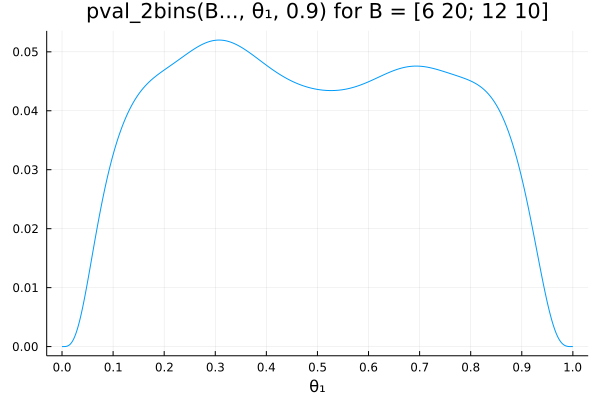

In [15]:
B = [
    6  20
    12 10
]

@show _pval_barnard(B..., 0.9)
θ1 = range(0, 1; length=1001)
p = pval_2bins.(B..., θ1, 0.9)
plot(θ1, p; label="", xtick=0:0.1:1, xlabel = "θ₁")
title!("pval_2bins(B..., θ₁, 0.9) for B = $B")

## 第一種の過誤が起こる確率を有意水準の函数としてプロット

In [16]:
function plot_pvalecdfs(dist_true; L = 10^5,
        plotPQ = trues(2), pvals = trues(6),
        size = (400count(plotPQ), 400), kwargs...
    )
    pvals[1] && (P_chisq = Vector{Float64}(undef, L))
    pvals[2] && (P_gtest = Vector{Float64}(undef, L))
    pvals[3] && (P_fisher = Vector{Float64}(undef, L))
    pvals[4] && (P_fisher_dos = Vector{Float64}(undef, L))
    pvals[5] && (P_barnard = Vector{Float64}(undef, L))
    pvals[6] && (P_logOR = Vector{Float64}(undef, L))
    
    Threads.@threads for i in 1:L
        A = rand(dist_true)
        pvals[1] && (P_chisq[i] = pval_chisq(A...))
        pvals[2] && (P_gtest[i] = pval_gtest(A...))
        pvals[3] && (P_fisher[i] = pval_fisher(A...))
        pvals[4] && (P_fisher_dos[i] = pval_fisher_dos(A...))
        pvals[5] && (P_barnard[i] = pval_barnard(A...))
        pvals[6] && (P_logOR[i] = pval_logOR(A...))
    end
    
    PP = []
    
    plotPQ[1] && begin
        P = plot()
        pvals[1] && plot!(StatsBase.ecdf(P_chisq); c=1, label="chisq")
        pvals[2] && plot!(StatsBase.ecdf(P_gtest); c=2, label="gtest", ls=:dash)
        pvals[3] && plot!(StatsBase.ecdf(P_fisher); c=3, label="fisher", ls=:dash)
        pvals[4] && plot!(StatsBase.ecdf(P_fisher_dos); c=4, label="fisher_dos", ls=:dashdot)
        pvals[5] && plot!(StatsBase.ecdf(P_barnard); c=5, label="barnard", ls=:dot)
        pvals[6] && plot!(StatsBase.ecdf(P_logOR); c=6, label="logOR", ls=:dot)
        plot!(identity; label="", c=:black, ls=:dot)
        plot!(; xtick = 0:0.1:1, ytick = 0:0.1:1)
        plot!(; xlim = (-0.05, 1.05), ylim = (-0.05, 1.05))
        push!(PP, P)
    end
    
    plotPQ[2] && begin
        Q = plot()
        pvals[1] && plot!(StatsBase.ecdf(P_chisq); c=1, label="chisq")
        pvals[2] && plot!(StatsBase.ecdf(P_gtest); c=2, label="gtest", ls=:dash)
        pvals[3] && plot!(StatsBase.ecdf(P_fisher); c=3, label="fisher", ls=:dash)
        pvals[4] && plot!(StatsBase.ecdf(P_fisher_dos); c=4, label="fisher_dos", ls=:dashdot)
        pvals[5] && plot!(StatsBase.ecdf(P_barnard); c=5, label="barnard", ls=:dot)
        pvals[6] && plot!(StatsBase.ecdf(P_logOR); c=6, label="logOR", ls=:dot)
        plot!(identity; label="", c=:black, ls=:dot)
        plot!(; xlim = (-0.005, 0.105), ylim = (-0.005, 0.105))
        plot!(; xtick = 0:0.01:1, ytick = 0:0.01:1)
        push!(PP, Q)
    end

    plot(PP...; size, kwargs...)
end

plot_pvalecdfs (generic function with 1 method)

### 小サンプルだが、χ²検定が十分に適切だと考えられる場合

極端な場合を除けば、小サンプルであっても、χ²検定の使用が十分に適切だと考えられる。

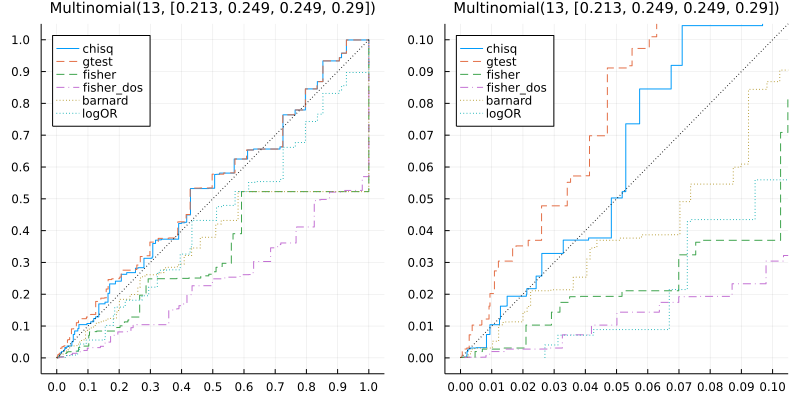

In [17]:
n = 13
p, q = 6//n, 6//n
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; title="Multinomial($n, $(round.(probs(dist_true), digits=3)))", titlefontsize=10)

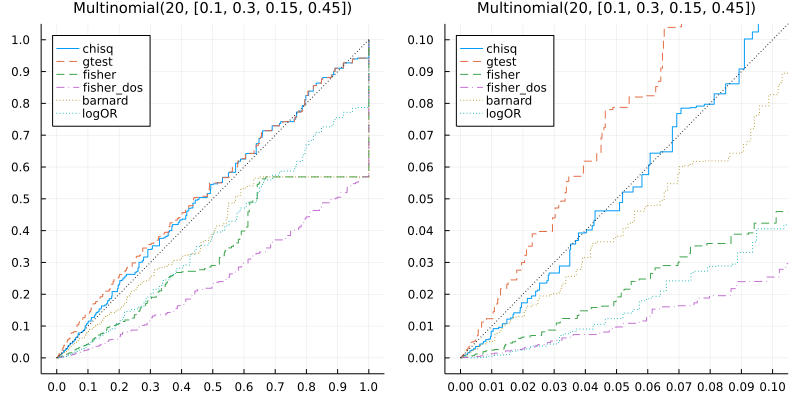

In [18]:
n = 20
p, q = 1//4, 2//5
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; title="Multinomial$(params(dist_true))", titlefontsize=10)

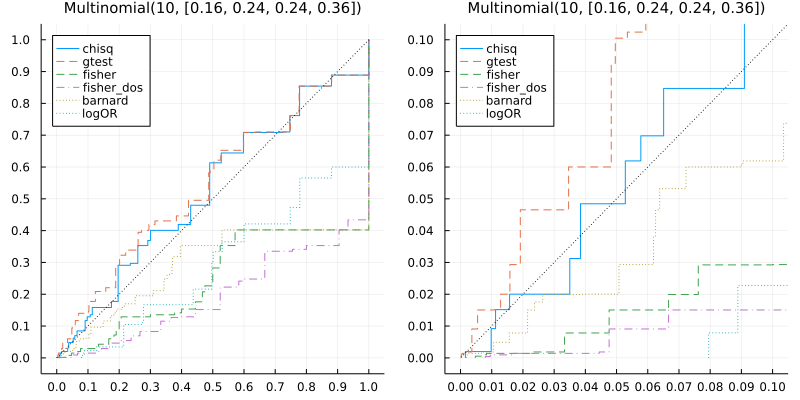

In [19]:
n = 10
p, q = 4//10, 4//10
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; title="Multinomial$(params(dist_true))", titlefontsize=10)

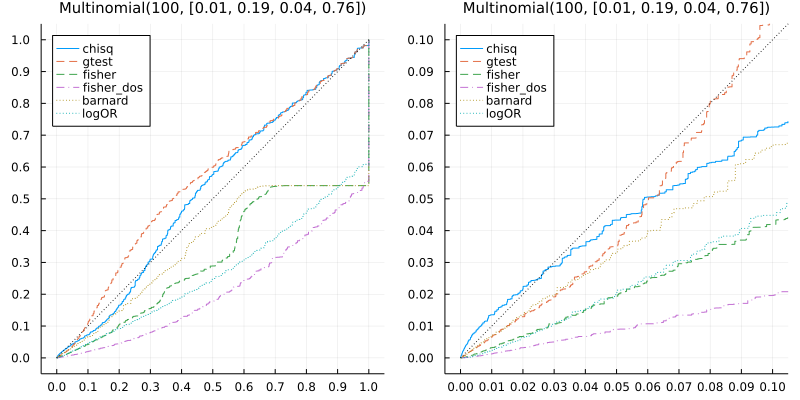

In [20]:
n = 100
p, q = 1//20, 1//5
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; title="Multinomial$(params(dist_true))", titlefontsize=10)

### χ²検定が不適切になるほど極端な場合

以下のような極端過ぎる設定のもとではχ²検定で第一種の過誤が起こる確率は大きくなってしまう。

非常に大雑把には０のセルがある場合にはχ²検定が不適切になりやすい。

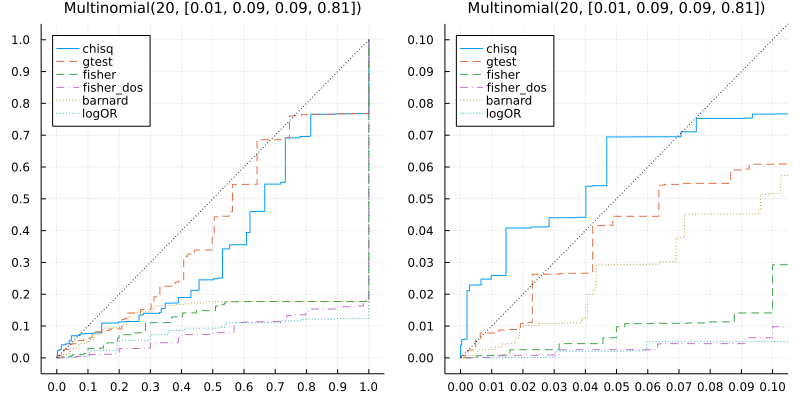

In [21]:
n = 20
p, q = 1//10, 1//10
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; title="Multinomial$(params(dist_true))", titlefontsize=10)

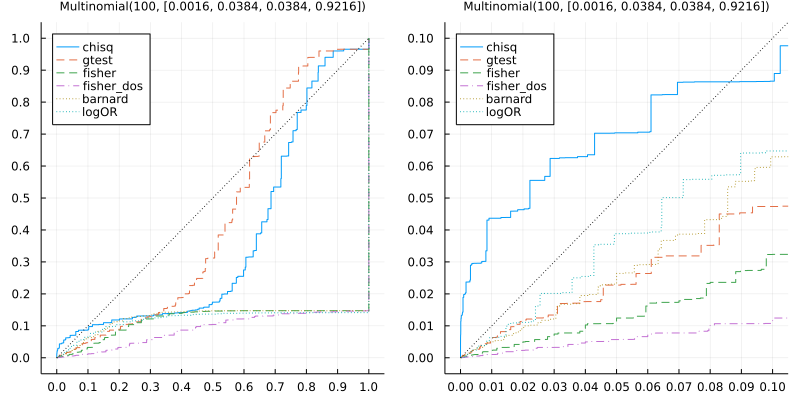

In [22]:
n = 100
p, q = 1//25, 1//25
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; 
    title="Multinomial$(params(dist_true))", titlefontsize=8)

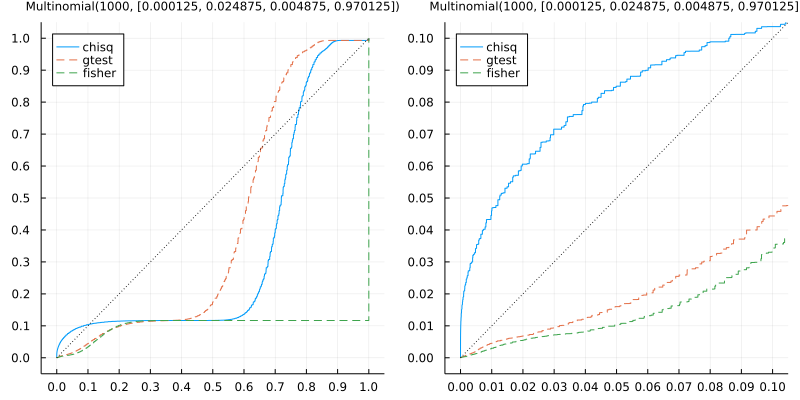

In [23]:
n = 1000
p, q = 1//200, 1//40
dist_true = Multinomial(n, Float64.(vec([p, 1-p]*[q, 1-q]')))
plot_pvalecdfs(dist_true; pvals = (tmp = trues(6); tmp[4:6] .= false; tmp),
    title="Multinomial$(params(dist_true))", titlefontsize=8)